In [1]:
# Import Libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Preprocessing and Pipeline libraries
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
import pickle

# Import time
import time

### Training Data

In [2]:
print("\nLoading training data...")
# load training data
training_data = pd.read_csv("mle-project-challenge/data/peerLoanTraining.csv", engine='python', header=0)
print("\nThere are ", len(training_data), "records in training data")
# # Separate out X and y
X_train = training_data.loc[:, training_data.columns != 'is_late']
# y_train = training_data.loc[:,training_data.columns == 'is_late']
y_train = training_data.iloc[:,-1:]


Loading training data...

There are  111068 records in training data


In [3]:
print("There are ",len(X_train.columns), "columns in x_train data")
print("There are ",len(y_train.columns), "columns in y_train data")
training_data.head()

There are  10 columns in x_train data
There are  1 columns in y_train data


,loan_amnt,int_rate,purpose,grade,annual_inc,revol_util,emp_length,dti,delinq_2yrs,home_ownership,is_late
0,12000,0.2039,credit_card,D,42000.0,0.647,10+ years,14.46,0,RENT,0
1,29150,0.2039,home_improvement,D,51000.0,0.404,10+ years,20.82,0,MORTGAGE,0
2,8000,0.1306,other,C,73000.0,0.560,10+ years,33.27,0,MORTGAGE,0
3,21000,0.0746,credit_card,A,60000.0,0.395,NaN,22.42,0,OWN,0
4,13000,0.1747,debt_consolidation,D,27500.0,0.185,4 years,26.45,0,RENT,0


### Load test data

In [4]:
print("\nLoading test data")
test_data = pd.read_csv("mle-project-challenge/data/peerLoanTest.csv", engine='python', header=0)
print("\nThere are ", len(test_data), "records in training data")
# Separate out X and y
X_test = test_data.loc[:, test_data.columns != 'is_late']
# y_test = test_data['is_late']
y_test = test_data.iloc[:, -1:]


Loading test data

There are  6843 records in training data


### Data Pre-Processing

In [6]:
numeric_features = ['loan_amnt', 
                    'int_rate', 'annual_inc', 'revol_util', 
                    'dti', 'delinq_2yrs'
                   ]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ])

categorical_features = ['purpose','grade', 'emp_length', 'home_ownership']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        ]
    )

In [8]:
# print(numeric_features)
# print('\n',numeric_transformer)
# print('\n',preprocess)

### Quick Exploratory Analysis

#### Check Null Values in Training Data

In [9]:
# training_data.isnull().values.any()
training_data.loc[:, training_data.isnull().any()].columns

Index(['revol_util', 'emp_length'], dtype='object')

In [10]:
# Check with count
training_data.loc[:, list(training_data.loc[:, training_data.isnull().any()].columns)].isnull().sum()

revol_util     117
emp_length    7747
dtype: int64

In [11]:
# set(training_data['revol_util'])

In [12]:
training_data['emp_length'].value_counts()

10+ years    37389
2 years      10577
3 years       9325
< 1 year      7615
1 year        7488
4 years       7445
5 years       7048
6 years       5282
7 years       4280
8 years       3753
9 years       3119
Name: emp_length, dtype: int64

#### Look at missing values visually 

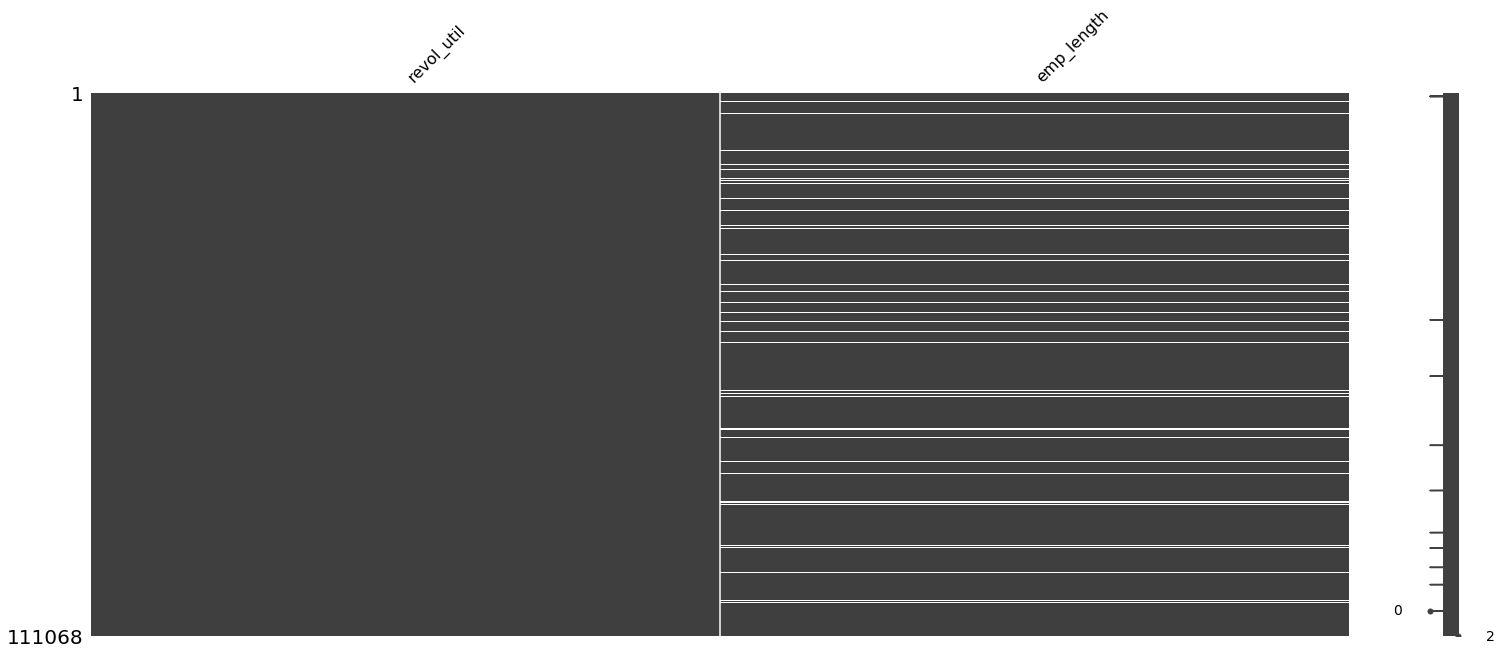

In [14]:
import missingno
missingdata_df = training_data.columns[training_data.isnull().any()].tolist()
missingno.matrix(training_data[missingdata_df])

##### Tes Data

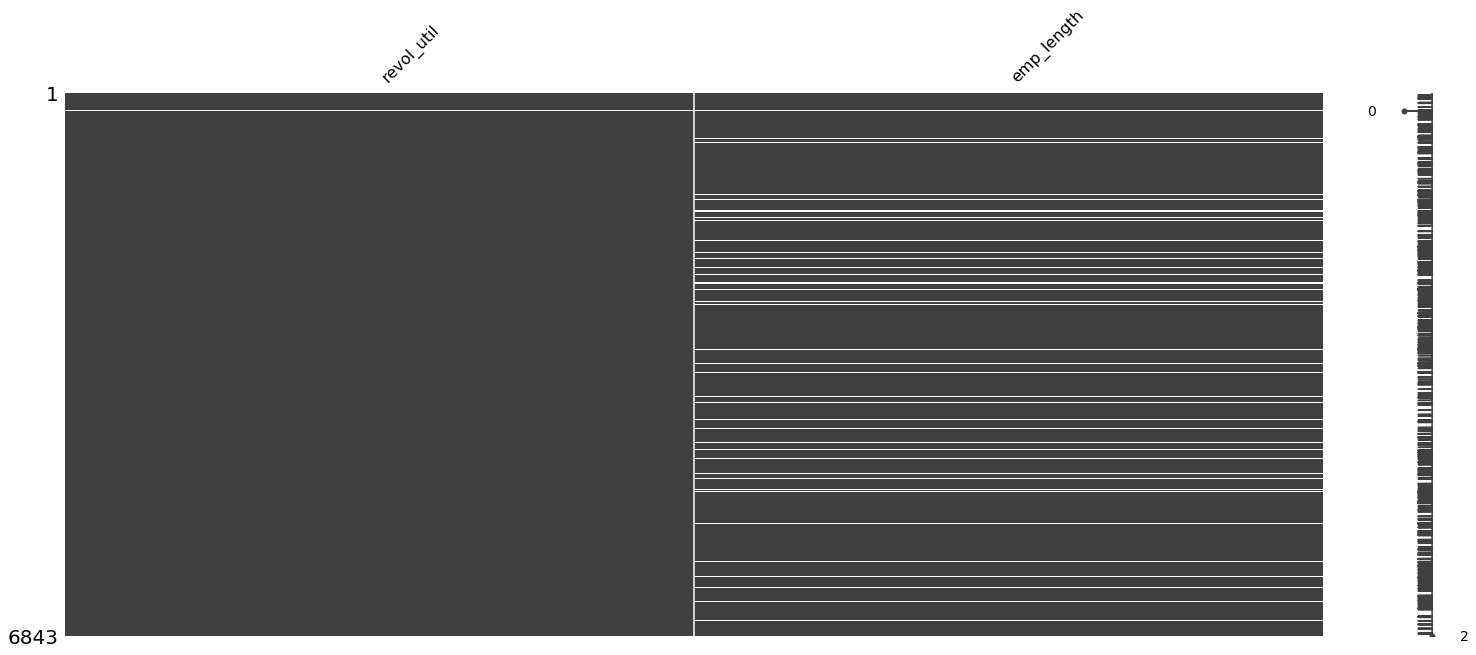

In [19]:
missingdata_df_test = test_data.columns[test_data.isnull().any()].tolist()
missingno.matrix(test_data[missingdata_df_test])

#### Check outcome varibale

In [15]:
training_data['is_late'].value_counts()

0    108608
1      2460
Name: is_late, dtype: int64

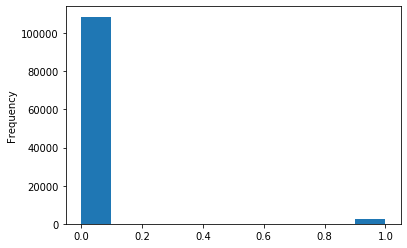

In [16]:
training_data['is_late'].plot(kind='hist')

In [17]:
test_data['is_late'].value_counts()

0    6748
1      95
Name: is_late, dtype: int64

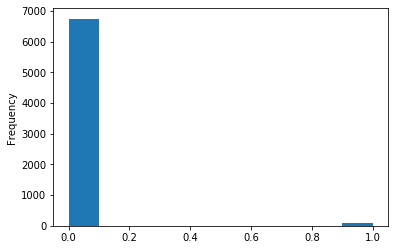

In [18]:
test_data['is_late'].plot(kind='hist')

#####  Check Percentage/Normalized

In [61]:
training_data['is_late'].value_counts(normalize=True)

0    0.977851
1    0.022149
Name: is_late, dtype: float64

In [60]:
test_data['is_late'].value_counts(normalize=True) 

0    0.986117
1    0.013883
Name: is_late, dtype: float64

In [ ]:
### Seems that data is imbalanced here. Combining data and shuffle it randomly would be one solution to get the data ditributed balanced

### Combine preprocessing with classifier

In [22]:
latePaymentsModel = make_pipeline(preprocess, RandomForestClassifier(random_state=42))

### Fit the pipeline to the training data (fit is for both the preprocessing and the classifier)

In [23]:
start_time = time.time()
print("\nTraining model ...")
latePaymentsModel.fit(X_train, y_train)
print("\n---Time to train default model %s seconds ---" % (time.time() - start_time))


Training model ...


C:\Users\NajaMohamed\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\NajaMohamed\Anaconda3\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



---Time to train default model 11.071707248687744 seconds ---


### Check Model Performance

In [24]:
prob = latePaymentsModel.predict_proba(X_test)
pos_probs = prob[:,0]

In [25]:
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
auc = roc_auc_score(y_test, pos_probs)
print('AUC: %.3f' % auc)

AUC: 0.380


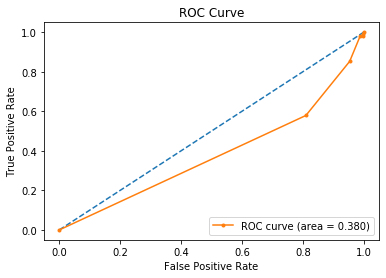

In [30]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, pos_probs)
# plot 
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.', label = 'ROC curve (area = %0.3f)' % auc)
# plot x, y axis labels
pyplot.xlabel("False Positive Rate")
pyplot.ylabel("True Positive Rate")
pyplot.legend(loc = 'lower right')
pyplot.title("ROC Curve")

# pyplot.savefig("new_model_mle_challenge/img/roc_curve_orig.jpg")
# show the plot
pyplot.show()

### Save the trained model as a pickle file

In [94]:
print("\nSaving model ...")
file = open('mle-project-challenge//models/latePaymentsModel.pkl', 'wb')
pickle.dump(latePaymentsModel, file)
file.close()


Saving model ...


### Load the pickled model

In [95]:
print("\nLoading saved model to make example predictions...")
pickledModel = pickle.load(open('mle-project-challenge//models/latePaymentsModel.pkl','rb'))


Loading saved model to make example predictions...


### Test Prediction on Static Data - Pay On Time

In [96]:
# Make a prediction for a likely on time payer
payOnTimePrediction = {
    'loan_amnt': [100],
    'int_rate': [0.02039],
    'purpose': ['credit_card'],
    'grade': ['A'],
    'annual_inc': [80000.00],
    'revol_util': [0.05],
    'emp_length': ['10+ years'],
    'dti': [1.46],
    'delinq_2yrs': [0],
    'home_ownership': ['RENT']
    }
payOnTimePredictionDf = pd.DataFrame.from_dict(payOnTimePrediction)

print("\nPredicting class probabilities for likely on-time payer:")
print(pickledModel.predict_proba(payOnTimePredictionDf))


Predicting class probabilities for likely on-time payer:
[[1. 0.]]


In [97]:
good_pred = pickledModel.predict_proba(payOnTimePredictionDf)

In [98]:
if good_pred[0][0] >= 0.9:
    risk = "No Risks Associated with the Profile and credit risk is {}".format(good_pred[0][1])
elif good_pred[0][0] < 0.9:
    risk = "Risks Associated with the profile and credit risk is {}".format(good_pred[0][1])
print(risk)

No Risks Associated with the Profile and credit risk is 0.0


### Test Prediction on Late Pay

In [99]:
# Prediction for a likely late payer
payLatePrediction = {
    'loan_amnt': [10000],
    'int_rate': [0.6],
    'purpose': ['credit_card'],
    'grade': ['D'],
    'annual_inc': [20000.00],
    'revol_util': [0.85],
    'emp_length': ['1 year'],
    'dti': [42.00],
    'delinq_2yrs': [4],
    'home_ownership': ['RENT']
    }
payLatePredictionDf = pd.DataFrame.from_dict(payLatePrediction)

print("\nPredicting class probabilities for a likely late payer:")
print(pickledModel.predict_proba(payLatePredictionDf))


Predicting class probabilities for a likely late payer:
[[0.7 0.3]]


In [104]:
bad_pred = pickledModel.predict_proba(payLatePredictionDf)
if bad_pred[0][0] >= 0.9:
    risk = "No Risks Associated with the Profile and credit risk is {}".format(bad_pred[0][1])
elif bad_pred[0][0] < 0.9:
    risk = "Risks Associated with the profile"
print(risk)

Risks Associated with the profile


In [101]:
payLatePredictionDf

,loan_amnt,int_rate,purpose,grade,annual_inc,revol_util,emp_length,dti,delinq_2yrs,home_ownership
0,10000,0.6,credit_card,D,20000.0,0.85,1 year,42.0,4,RENT


### Predict class probabilities for a set of records using the test set -List of Values

In [49]:
print("\nPredicting class probabilities for the test data set:")
print(pickledModel.predict_proba(X_test))
all_probs = pickledModel.predict_proba(X_test)


Predicting class probabilities for the test data set:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


### Check Model Accuracy With Test Data

In [42]:
from sklearn.metrics import accuracy_score
print("Accuracy:\n%s" % accuracy_score(y_test, pickledModel.predict(X_test)))

Accuracy:
0.9861172000584539
